# Projekt przetwarzania tekstu i analizy sentymentu komentarzy pod postem Reddit.
Link do postu: https://www.reddit.com/r/coolguides/comments/172z892/a_cool_guide_on_the_human_cost_of_the/?sort=old
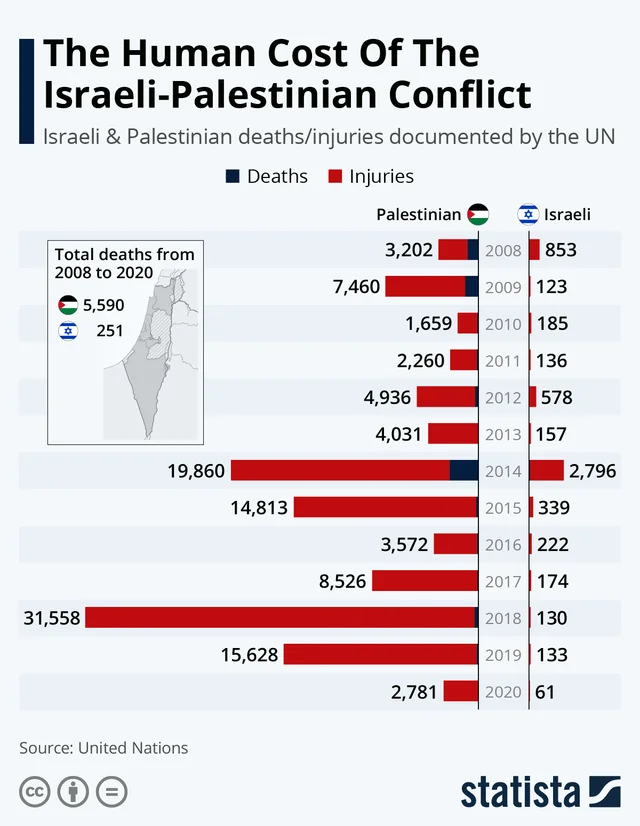

Post jest informacyjny i przedstawia statyski zebrane przez niemiecką firę https://www.statista.com/ 
Dane zostały udostępnione przez ONZ. Post został udostępniony przez profil https://www.reddit.com/r/coolguides/ i wywołał niemałą dyskusję w komenatarzach (ponad 6000 komentarzy). Dzięki bibliotece "praw" byłem w stanie bez problemu pobrać wszystkie komentarze oraz inne potrzebne mi dane.

In [1]:
import praw
import os 
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
reddit = praw.Reddit(user_agent=True, client_id=os.getenv("CLIENT_ID"), client_secret=os.getenv("CLIENT_SECRET"), username=os.getenv("USERNAME"), password=os.getenv("PASSWORD"))

In [4]:
url = "https://www.reddit.com/r/coolguides/comments/172z892/a_cool_guide_on_the_human_cost_of_the/"

In [5]:
from datetime import datetime, timedelta

In [6]:
def get_comments(post_url):
    post = reddit.submission(url=post_url)
    post.comments.replace_more(limit=None)
    comments_data = []

    for comment in post.comments.list():
        comment_body = comment.body
        comment_time = datetime.utcfromtimestamp(comment.created_utc).strftime('%Y-%m-%d %H:%M:%S')
        
        comment_info = (comment_body, comment_time)
        comments_data.append(comment_info)

    return comments_data

In [7]:
comments_data = get_comments(url)

In [8]:
len(comments_data)

6079

In [9]:
def filter_comments(comments_tuple):
    filtered_comments = [(comment, timestamp) for comment, timestamp in comments_tuple if comment not in ('', "[deleted]") and "http" not in comment]
    return filtered_comments

In [10]:
comments_data = filter_comments(comments_data)

In [11]:
len(comments_data)

5687

In [12]:
comments_text = [comment for comment, timestamp in comments_data]

In [13]:
joined_comments = ''.join(comments_text)

In [14]:
import nltk
nltk.download("all")

/Users/nwielocha/anaconda3/lib/python3.11/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/nwielocha/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/nwielocha/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/nwielocha/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/nwielocha/nltk_data...
[nltk_data]    |   Package aver

True

In [15]:
def tokenize(data):
    tokens = nltk.word_tokenize(data)
    tokens = [t for t in tokens if t.isalpha()]
    return tokens

In [16]:
tokens = tokenize(joined_comments)
print("Liczba słów po tokenyzacji: ", len(tokens))

Liczba słów po tokenyzacji:  199391


In [17]:
def get_stopwords(filename):
    stopwords = nltk.corpus.stopwords.words("english")
    with open(filename, 'r') as file:
        missed_stopwords_list = [line.strip() for line in file]

    for w in missed_stopwords_list:
        if w not in stopwords:
            stopwords.append(w)
    return stopwords

In [18]:
def delete_stopwords(tokens):
    stopwords = get_stopwords("stopwords.txt")
    filtered_tokens = [t for t in tokens if t.lower() not in stopwords]
    return filtered_tokens

In [19]:
filtered_tokens = delete_stopwords(tokens)
print("Liczba słów po usunięciu stopwords: ", len(filtered_tokens))

Liczba słów po usunięciu stopwords:  98206


In [20]:
def lemmatize(filtered_tokens):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(t) for t in filtered_tokens]
    return lemmatized_tokens

In [21]:
lemmatized_tokens = lemmatize(filtered_tokens)
print("Liczba słów po lematyzacji: ", len(lemmatized_tokens))

Liczba słów po lematyzacji:  98206


In [22]:
def freq_dist(lemmatized_tokens):
    fd = nltk.FreqDist(lemmatized_tokens).most_common(10)
    return fd

In [23]:
fd = freq_dist(lemmatized_tokens)

In [24]:
import matplotlib.pyplot as plt

In [25]:
def freq_dist_plot(fd):
    words, freq = zip(*fd)
    plt.figure(figsize=(10, 6))
    plt.bar(words, freq, color="skyblue")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.title("Frequency Distribution")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    # plt.savefig("freq_dist.png")
    plt.show()

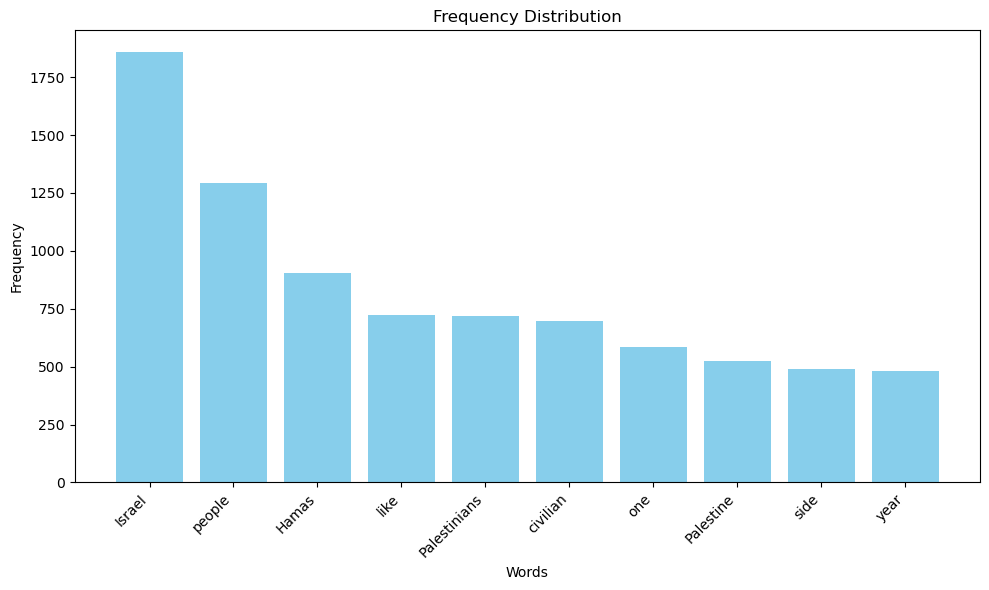

In [26]:
freq_dist_plot(fd)

In [27]:
from wordcloud import WordCloud

In [28]:
def wordcloud(tokens):
    stopwords = get_stopwords("stopwords.txt")
    text = ' '.join(tokens)
    wordcloud = WordCloud(stopwords=stopwords).generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    # plt.savefig("wordcloud.png")
    plt.show()

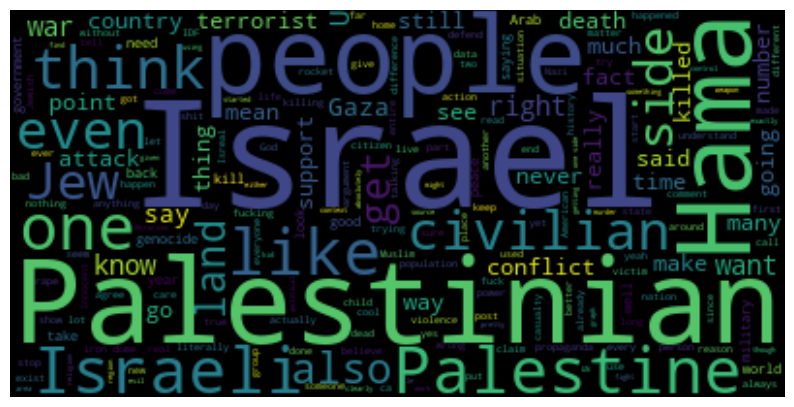

In [29]:
wordcloud(lemmatized_tokens)

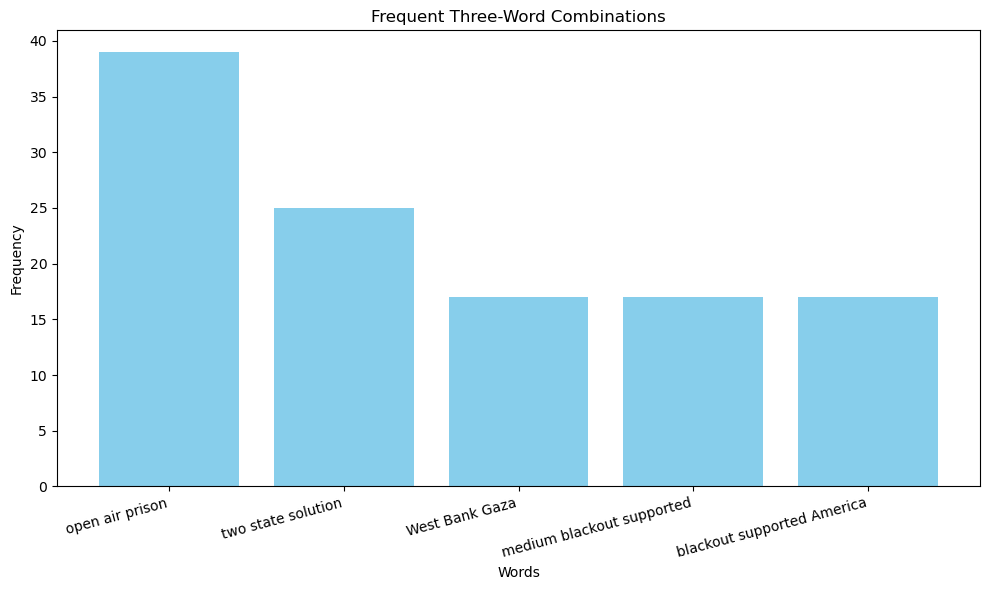

In [30]:
finder = nltk.collocations.TrigramCollocationFinder.from_words(lemmatized_tokens)
trigram_fd = finder.ngram_fd.most_common(5)
tuples, freq = zip(*trigram_fd)
words = [' '.join(t) for t in tuples]
plt.figure(figsize=(10, 6))
plt.bar(words, freq, color="skyblue", align="center")
plt.xticks(rotation=15, ha='right')
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Frequent Three-Word Combinations")
plt.tight_layout()
# plt.savefig("trigram_freq_dist.png")
plt.show()

Dwupaństwowe rozwiązanie konfliktu (two state solution) izraelsko-palestyńskiego przewiduje utworzenie niezależnego państwa Palestyna obok państwa Izrael, w regionie na zachód od rzeki Jordan.

In [31]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [32]:
def get_sentiment(comments_text):
    sia = SentimentIntensityAnalyzer()
    compound_scores = [sia.polarity_scores(
        comment)['compound'] for comment in comments_text]
    average_score = sum(compound_scores) / len(compound_scores)

    if average_score > 0:
        return f"Positive: {average_score}"
    elif average_score < 0:
        return f"Negative: {average_score}"
    else:
        return "Neutral"

In [33]:
overal_sentiment = get_sentiment(comments_text)
overal_sentiment

'Negative: -0.19122542641111354'

In [34]:
from collections import defaultdict

In [35]:
def get_sentiment_over_time(comments_data):
    sia = SentimentIntensityAnalyzer()
    comments, timestamps = zip(*comments_data)
    compound_scores = [sia.polarity_scores(comment)['compound'] for comment in comments]

    datetime_timestamps = [datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S') for timestamp in timestamps]

    sentiment_aggregated = defaultdict(list)
    for timestamp, score in zip(datetime_timestamps, compound_scores):
        sentiment_aggregated[timestamp.replace(hour=0, minute=0, second=0, microsecond=0)].append(score)

    aggregated_timestamps = sorted(sentiment_aggregated.keys())
    aggregated_scores = [sum(sentiment_aggregated[timestamp]) / len(sentiment_aggregated[timestamp]) for timestamp in aggregated_timestamps]

    plt.figure(figsize=(10, 6))
    plt.bar(aggregated_timestamps, aggregated_scores)
    plt.title(f'Sentiment Over Time (Daily)')
    plt.xlabel('Timestamp')
    plt.ylabel('Average Sentiment Compound Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

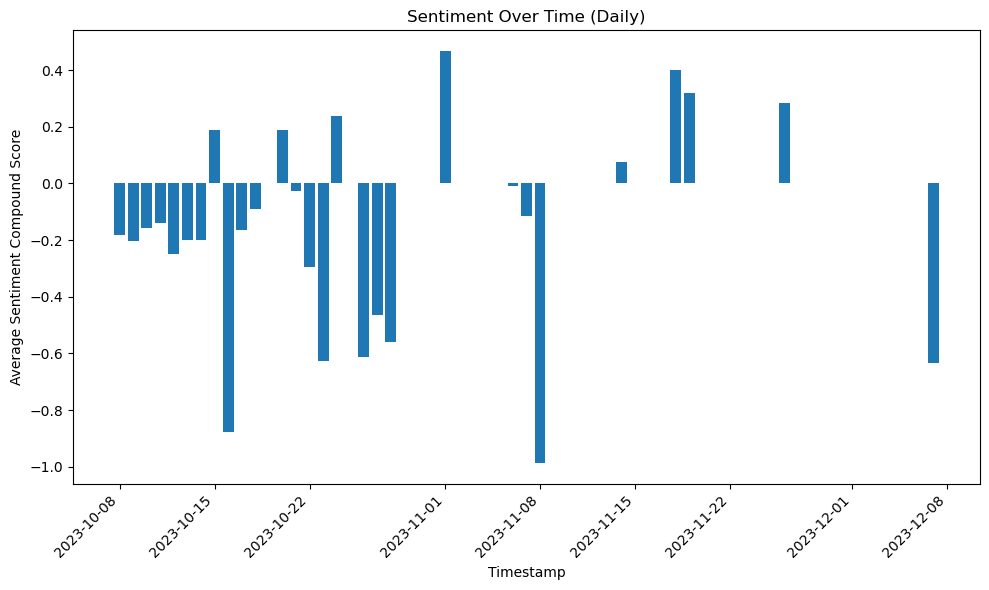

In [36]:
get_sentiment_over_time(comments_data)

In [65]:
def comments_per_day(comments_data):
    datetime_timestamps = [datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S') for _, timestamp in comments_data]
    
    comments_per_day = defaultdict(int)
    for timestamp in datetime_timestamps:
        date_key = timestamp.date()
        comments_per_day[date_key] += 1
    dates, comment_counts = zip(*sorted(comments_per_day.items()))

    plt.figure(figsize=(10, 6))
    plt.plot(dates, comment_counts)
    plt.title('Daily Number of Comments')
    plt.xlabel('Date')
    plt.ylabel('Number of Comments')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()

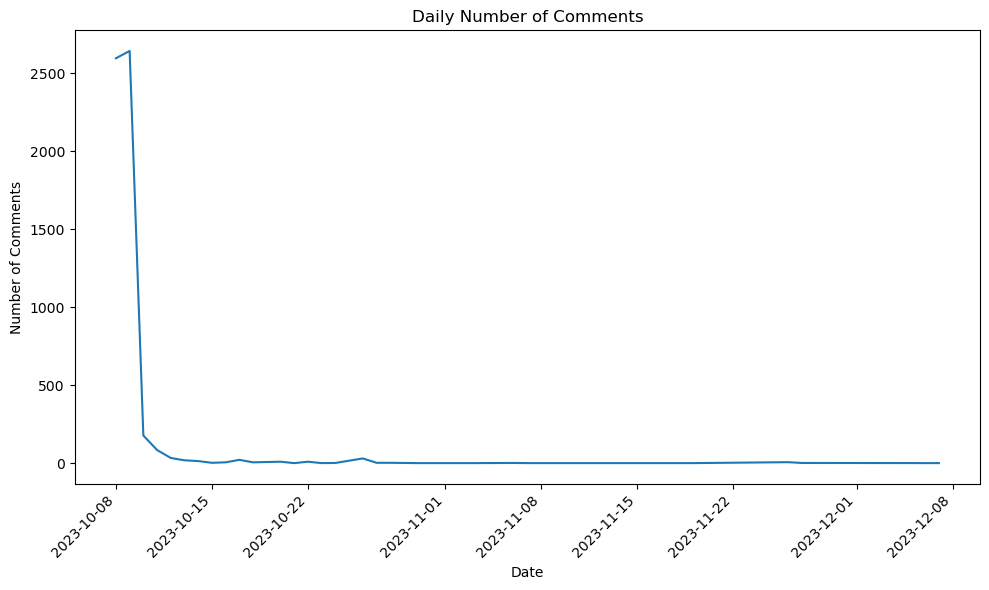

In [66]:
comments_per_day(comments_data)

In [37]:
timestamps = [timestamp for comment, timestamp in comments_data]
datetime_timestamps = [datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S') for timestamp in timestamps]

In [38]:
first_comment_time = min(datetime_timestamps)
last_comment_time = max(datetime_timestamps)
print(f"Date and time of the first comment: {first_comment_time}")
print(f"Date and time of the last comment: {last_comment_time}")

Date and time of the first comment: 2023-10-08 13:34:14
Date and time of the last comment: 2023-12-07 21:21:20


7 pazdziernika 2023 roku Hamas zaatakował państwo israelskie. Post powstał dzień po tym dniu, a z nim przyszedł pierwszy komentarz. Ostatni komentarz był odnotowany dokładnie 2 miesiące od ataku.

In [39]:
def get_sentiment_on_date(comments_data, target_date):
    sia = SentimentIntensityAnalyzer()
    comments, timestamps = zip(*comments_data)
    datetime_timestamps = [datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S') for timestamp in timestamps]
    target_date_comments = [comment for comment, timestamp in zip(comments, datetime_timestamps) if timestamp.date() == target_date]

    compound_scores = [sia.polarity_scores(comment)['compound'] for comment in target_date_comments]

    if compound_scores:
        average_score = sum(compound_scores) / len(compound_scores)
        return f"Average Sentiment on {target_date}: {average_score}"
    else:
        return f"No comments on {target_date}"

In [40]:
target_date = datetime.strptime('2023-10-16', '%Y-%m-%d').date()
result = get_sentiment_on_date(comments_data, target_date)
result

'Average Sentiment on 2023-10-16: -0.8785'

Dla potwierdzenia widzimy, że to dokładnie dnia 16 października drastycznie spadł sentyment. Ze względu na różnice czasowe na całym świecie
sprawdźmy co działo się między 15 a 17 października.
Źródło: https://en.wikipedia.org/wiki/Timeline_of_the_Israel%E2%80%93Hamas_war

## 15 October

    - Israel Border Police arrested more than 50 Palestinians in the occupied West Bank according the Palestinian news agency Wafa. Minor clashes between Hezbollah and the IDF continued in and around the Shebaa Farms[81] and elsewhere at the Lebanon–Israel border.[81]
    - Israel informed US National Security Advisor Jake Sullivan that water pipes had been turned back on in southern Gaza.[82]
    - The Egyptian Red Crescent, WHO, and other NGOs and volunteer groups began stockpiling humanitarian supplies at Rafah Crossing.[83]
    UNRWA chief Philippe Lazzarini noted that Gaza's supply of clean drinking water was running out, stating at a press conference that Gaza "was running out of life".[84]
    - Four Gazan hospitals were rendered inoperable while the IDF demanded that 21 hospitals in northern Gaza evacuate according to the WHO.[85]
    - The Committee to Protect Journalists said at least twelve journalists had been killed and eight wounded to date, while two others were missing.[86] They variously free-lanced or worked for Agence France-Press, Ain Media, Al-Aqsa Radio, Al-Ghad, Al-Jazeera, Al-Khamsa News, Fourth Authority News Agency, Khabar Agency, Israel Hayom, Sky News Arabia, Reuters, Sowt Al-Asra Radio (Radio Voice of the Prisoners, and Smart Media.[87]

## 16 October

    - The carrier USS Eisenhower left Naval Station Norfolk in Virginia to join the USS Gerald R. Ford as an added measure of deterrence in the eastern Mediterranean.[88][89]
    - Iran threatened "pre-emptive" attacks against Israel, indicating further region-wide escalation of the war.[90][91]
    - President Biden in an interview on 60 Minutes said that an Israeli occupation of Gaza "would be a big mistake", adding that he was "confident Israel will act under the rules of war".[92][93] He also said that Hamas must be eliminated, that there must be a path to a Palestinian state,[63] and regarded the initial Hamas attack as consequential as "The Holocaust".[94]
    - Khan Yunis, a city of 400,000, was swamped by a million refugees.[63]
    - Hamas released its first video of a hostage (an Israeli). Abu Obeida, the spokesperson for the military wing of Hamas, claimed that the group was holding ~200 hostages, with "dozens" in the hands of various factions.[95][96][97]
    - Israel attacked the Rafah border crossing.[98]
    - Israeli Minister without portfolio Gideon Sa'ar stated that "Gaza must be smaller at the end of the war".[99]
    - The World Health Organization stated there were only "24 hours of water, electricity and fuel left" before "a real catastrophe" in Gaza.[100]

## 17 October
See also: October 2023 UNRWA school airstrike and Al-Ahli Arab Hospital explosion

    - An explosion occurred at the al-Ahli Arab Hospital where thousands of displaced Palestinians were seeking shelter; the initial estimated fatalities ranged in the hundreds. The IDF claimed that a Palestinian Islamic Jihad (PIJ) rocket attack had failed, whereas the Gazan Health ministry claimed that it was an IAF air strike;[1][101] independent analysis indicated that it was likely a failed rocket attack.[102][103] Protests erupted worldwide,[104] including in Ramallah and Hebron in the occupied West Bank.[105][106] Protestors from Ramallah demanded the "downfall" of Palestinian president Mahmoud Abbas.[107]
    - The US State Department raised its travel advisory to Lebanon to Level 4: Do Not Travel.[108]

In [41]:
target_date = datetime.strptime('2023-10-26', '%Y-%m-%d').date()
result = get_sentiment_on_date(comments_data, target_date)
result

'Average Sentiment on 2023-10-26: -0.6112903225806451'

In [42]:
target_date = datetime.strptime('2023-10-27', '%Y-%m-%d').date()
result = get_sentiment_on_date(comments_data, target_date)
result

'Average Sentiment on 2023-10-27: -0.4643'

In [43]:
target_date = datetime.strptime('2023-10-28', '%Y-%m-%d').date()
result = get_sentiment_on_date(comments_data, target_date)
result

'Average Sentiment on 2023-10-28: -0.5595'

Kilkudniowy spadek sentymentu widzimy w okresie 26-28 października. W tych dniach przyczyną negatywnych emocji w komentarzach mogła być wymiana ataków rakiet z dwóch stron.
## 27 October

    - Israel conducted a heavy round of airstrikes and said that it was "expanding its ground forces" in besieged Gaza.[159] Several of these air strikes reportedly hit near the vicinity of both al-Shifa Hospital and the Indonesia Hospital.[160]
    - Hamas launched rockets from Gaza that hit apartment blocks in Tel Aviv.[161]
    - Gaza suffered a complete communications blackout. ActionAid stated it was "nearly impossible" for people to call or receive emergency services.[162]

## 28 October

    - Israel began an invasion of the Gaza Strip, launching a large-scale ground assault on the towns of Beit Hanoun and Bureij.[163]

In [44]:
target_date = datetime.strptime('2023-11-01', '%Y-%m-%d').date()
result = get_sentiment_on_date(comments_data, target_date)
result

'Average Sentiment on 2023-11-01: 0.4678'

Pierwszy dzień listopada, według analizy najbardziej pozytywny dzień w kontekście komenatrzy pod analizowanym postem.

## 1 November

    - The Lions' Den called for all Palestinians to confront Israel.[171]
    - An Israeli armored unit was spotted west of Al-Mughraqa.[171]
    - The IAF attacked the Jabalia refugee camp in the Gaza Strip, leading to massive casualties.[172]
    - IAF air strikes interrupted prayers at the Holy Family Church in Gaza.[173]

Dokładna analiza komentarzy z tego dnia:

In [45]:
def get_comments_on_date(comments_data, target_date):
    comments, timestamps = zip(*comments_data)
    datetime_timestamps = [datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S') for timestamp in timestamps]

    target_date_comments = [comment for comment, timestamp in zip(comments, datetime_timestamps) if timestamp.date() == target_date]

    return target_date_comments

In [46]:
target_date = datetime.strptime('2023-11-01', '%Y-%m-%d').date()
comments_on_date = get_comments_on_date(comments_data, target_date)

In [47]:
comments_on_date

['its funny how you talk about war in \'48 but then say "..and the support of Israel was America and France in 1973.." what?']

In [67]:
target_date = datetime.strptime('2023-11-08', '%Y-%m-%d').date()
comments_on_date = get_comments_on_date(comments_data, target_date)

In [68]:
comments_on_date

["The social justice warrior brigade love to back the poor old terrorists who's  culture is deliberate and celebrated murder. Only the west backed are the bad guys. Never mind the fact no one is jumping up and down about the actual genocide of tens of millions of Muslims in China right now. \n\nIsrael: we have nuclear weapons but use only the nessasary force to minimize our own losses because we are few and are out numbered and surrounded. (Defensive doctrine)\n\nHamas: murder all Isreal. Brainwash and use of fear to control our own men,women,children to die for our cause. Would not hesitate to nuke Isreal in a heartbeat if we had the weapons to do so. \n\nChina: we can do what we want because we make all your stuff way cheaper than you can.  Bomb us and you will have to pay $30,000 for your next iPhone."]

In [48]:
def most_commented_day(comments_data):
    _, timestamps = zip(*comments_data)
    datetime_timestamps = [datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S') for timestamp in timestamps]

    comments_per_day = {}
    for timestamp in datetime_timestamps:
        date_key = timestamp.date()
        comments_per_day[date_key] = comments_per_day.get(date_key, 0) + 1

    most_commented_day = max(comments_per_day, key=comments_per_day.get)
    most_comments_count = comments_per_day[most_commented_day]

    return most_commented_day, most_comments_count

In [49]:
most_commented_day(comments_data)

(datetime.date(2023, 10, 9), 2643)

In [50]:
target_date = datetime.strptime('2023-10-09', '%Y-%m-%d').date()
comments_on_date = get_comments_on_date(comments_data, target_date)

In [51]:
tokens = tokenize(''.join(comments_on_date))
len(tokens)

96595

In [52]:
filtered_tokens = delete_stopwords(tokens)
len(filtered_tokens)

47537

In [53]:
lemmatized_tokens = lemmatize(filtered_tokens)
len(lemmatized_tokens)

47537

In [54]:
fd = freq_dist(lemmatized_tokens)

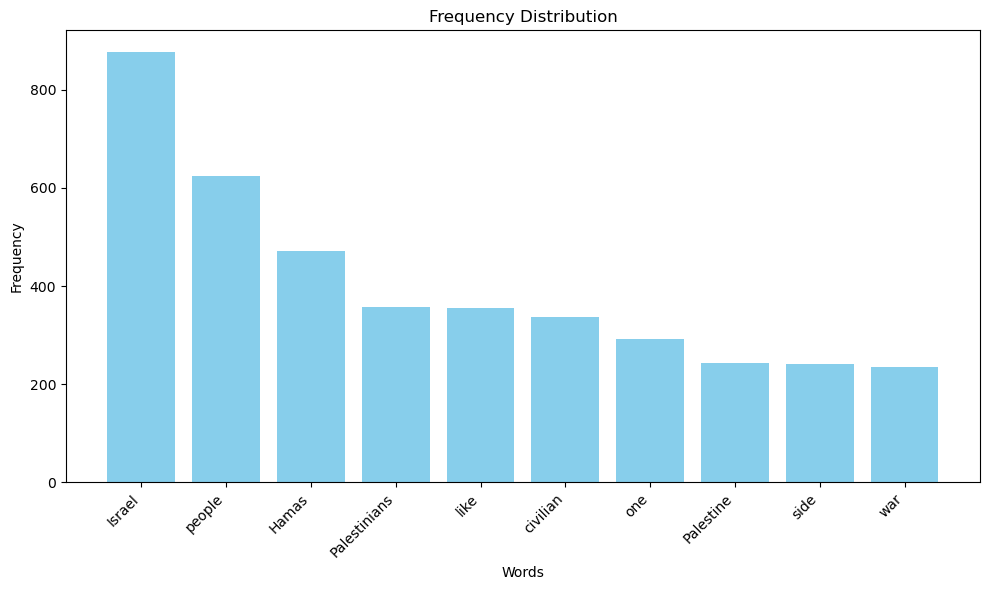

In [55]:
freq_dist_plot(fd)

In [56]:
from nltk.text import Text

In [57]:
text_object = Text(tokens)

In [69]:
concordance_results = text_object.concordance('israel', lines=20)

Displaying 20 of 929 matches:
If the Palestinian had the military Israel does then Israel would be long assu
n had the military Israel does then Israel would be long assume that this does
sed by medical shipments blocked by Israel Israel is the victim More like Isra
medical shipments blocked by Israel Israel is the victim More like Israel buys
rael Israel is the victim More like Israel buys our shit from Boeing Northrop 
d atrocities our government commits Israel is not an ally Israel is our dog fi
nment commits Israel is not an ally Israel is our dog fighting in the ring and
is in mind are CONSTANTLY attacking Israel a lot of it is intercepted by the i
nians get more injuries Why Because Israel is winning This graph literally is 
sraeli Its complicated usa supports Israel and iran supports Palestine unfortu
 missiles mostly on civilians While Israel is building itself Gaza makes all e
f Gaza makes all efforts to destroy Israel instead of building a guide but a c
etting their asses kic